In [60]:
# (a) Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras

In [61]:
# (b) Upload / access the dataset
data = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\LP4\creditcard.csv")

# Separate features and labels
X = data.drop("Class", axis = 1).values
y = data["Class"].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [62]:
# (c) Encoder – converts input into latent representation
input_dim = X.shape[1]
input_layer = keras.layers.Input(shape=(input_dim,))
encoded = keras.layers.Dense(32, activation="relu")(input_layer)
encoded = keras.layers.Dense(16, activation="relu")(encoded)
encoded = keras.layers.Dense(8,  activation="relu")(encoded)
encoded = keras.layers.Dense(4,  activation="relu")(encoded)

In [63]:
# (d) Decoder – reconstructs input from latent representation
decoded = keras.layers.Dense(8, activation="relu")(encoded)
decoded = keras.layers.Dense(input_dim, activation="sigmoid")(decoded)

# Define Autoencoder
autoencoder = keras.models.Model(inputs = input_layer, outputs = decoded)

In [64]:
# (e) Compile model with optimizer, loss, and metrics
adam = Adam(0.001)
autoencoder.compile(loss="mse", optimizer=adam, metrics=["mae"])

# Train only on normal transactions
X_train = X[y == 0]
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle = True, verbose = 1)

Epoch 1/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.8712 - mae: 0.6132
Epoch 2/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8434 - mae: 0.5988
Epoch 3/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 981us/step - loss: 0.8360 - mae: 0.5951
Epoch 4/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 986us/step - loss: 0.8321 - mae: 0.5931
Epoch 5/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 965us/step - loss: 0.8302 - mae: 0.5919
Epoch 6/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 969us/step - loss: 0.8285 - mae: 0.5907
Epoch 7/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 967us/step - loss: 0.8272 - mae: 0.5895
Epoch 8/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 964us/step - loss: 0.8257 - mae: 0.5880
Epoch 9/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8236 - mae: 0.5869
Epoch 10/10
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 983us/step - loss: 0.8219 - mae: 0.5861


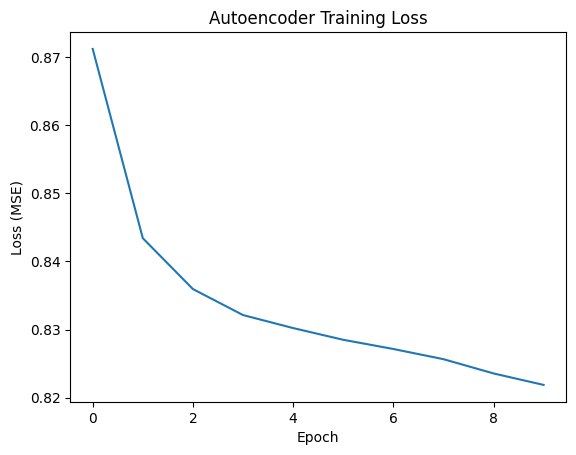

In [65]:
# Visualization – training loss over epochs
plt.plot(history.history['loss'])
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.show()

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 590us/step
Reconstruction error threshold: 14.75141

Model Accuracy: 99.53%

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    284315
       Fraud       0.15      0.39      0.22       492

    accuracy                           1.00    284807
   macro avg       0.58      0.69      0.61    284807
weighted avg       1.00      1.00      1.00    284807


Confusion Matrix:
[[283269   1046]
 [   302    190]]


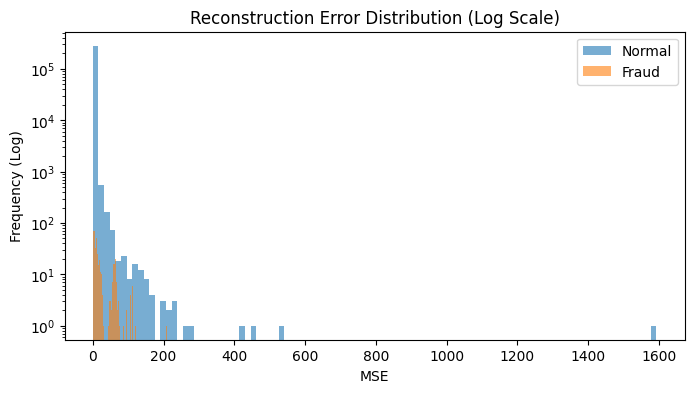

In [70]:
# --- Step 1: Reconstruction for all data ---
reconstructed = autoencoder.predict(X)
mse = np.mean(np.power(X - reconstructed, 2), axis=1)

# --- Step 2: Set threshold (mean + 3*std of normal errors) ---
threshold = np.mean(mse[y == 0]) + 3 * np.std(mse[y == 0])
print(f"Reconstruction error threshold: {threshold:.5f}")

# --- Step 3: Classify anomalies ---
y_pred = (mse > threshold).astype(int)  # 1 = Fraud, 0 = Normal

# --- Step 4: Evaluation ---
acc = accuracy_score(y, y_pred)
print(f"\nModel Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["Normal", "Fraud"]))
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

# --- Step 5: Visualize Reconstruction Error ---
plt.figure(figsize=(8,4))
plt.hist(mse[y == 0], bins=100, alpha=0.6, label='Normal')
plt.hist(mse[y == 1], bins=100, alpha=0.6, label='Fraud')
plt.yscale("log")
plt.title("Reconstruction Error Distribution (Log Scale)")
plt.xlabel("MSE")
plt.ylabel("Frequency (Log)")
plt.legend()
plt.show()

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

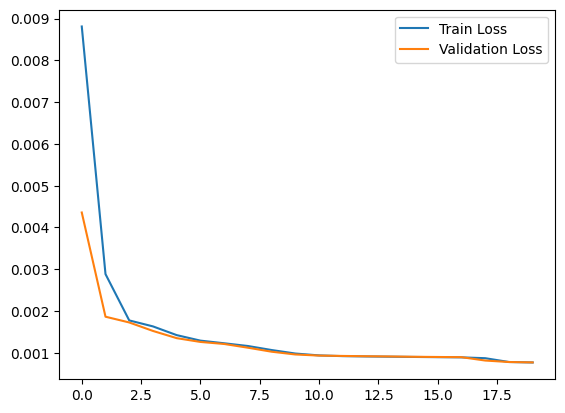

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step
Threshold: 0.0025246143520618997
Count of anomalies in test data: 1463
Accuracy: 0.9755802113689829
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.87      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\LP4\creditcard.csv")

print(data.head())

# Separate features and labels
features = data.drop("Class", axis=1).values
labels = data["Class"].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Use only normal transactions (Class = 0) for training
x_train_normal = x_train[y_train == 0]

# Scale data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_normal)
x_test_scaled = scaler.transform(x_test)

# Autoencoder model
input_dim = x_train_scaled.shape[1]

encoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu")
], name='encoder')

decoder = models.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(input_dim, activation='sigmoid')
], name='decoder')

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

# Train model
history = autoencoder.fit(x_train_scaled, x_train_scaled, 
                          epochs=20, batch_size=256, 
                          validation_split=0.2, verbose=1)

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Compute reconstruction error
reconstructions = autoencoder.predict(x_test_scaled)
mse = np.mean(np.power(x_test_scaled - reconstructions, 2), axis=1)

# Set threshold
threshold = np.mean(mse) + np.std(mse)
print("Threshold:", threshold)

# Identify anomalies
predictions = (mse > threshold).astype(int)

# ✅ Count anomalies
print(f"Count of anomalies in test data: {np.sum(predictions)}")

# Evaluate
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
